# Car Price Prediction

In [1]:
# import the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")


In [2]:
# import the data
car_price_init = pd.read_csv('car_price.csv')
# print the first few rows
car_price_init.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


## Data Preparation


In [3]:
# make a copy of the data
car_price = car_price_init.copy()

### Check data information

There are 11914 entries and 16 columns with some columns having missing values

In [4]:
# check data info
car_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

### Check for missing values

The columns **Engine Fuel Type, Engine HP, Engine Cylinders, Number of Doors** have very few number of missing values compared to the total entries available but the **Market Category** column has too many missing values so we will have to drop this particular column and drop missing values in others 

In [5]:
# check for missing values
car_price.isna().sum()/100

Make                  0.00
Model                 0.00
Year                  0.00
Engine Fuel Type      0.03
Engine HP             0.69
Engine Cylinders      0.30
Transmission Type     0.00
Driven_Wheels         0.00
Number of Doors       0.06
Market Category      37.42
Vehicle Size          0.00
Vehicle Style         0.00
highway MPG           0.00
city mpg              0.00
Popularity            0.00
MSRP                  0.00
dtype: float64

### Drop columns of no interest

Make,
Model,
Year,
Engine HP,
Engine Cylinders,
Transmission Type,
Vehicle Style,
highway MPG,
city mpg

In [6]:
# initiate columns to be dropped
# columns_drop = ['Engine Fuel Type', 'Transmission Type',
#               'Driver Wheels', 'Number of Doors',
#              'Market Category', 'Vehicle Size',
#               'Popularity']

# drop this columns 
car_price.drop(car_price.columns[[3, 7, 8, 9, 10, 14]], axis = 1, inplace = True)

In [7]:
# check the resulting dataframe
car_price.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


### Replace the whitespace in the columns name with **_** 

In [8]:
# replace the hitesace in column names with '_'
car_price.columns = car_price.columns.str.replace(' ', '_').str.lower()

In [9]:
# check 
car_price.head(2)

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650


### Replace missing values with 0


In [10]:
# replace missing values of selected columns with 0
columns = ['engine_hp', 'engine_cylinders']
car_price[columns] = car_price[columns].fillna(0)

In [11]:
# check
car_price.isna().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64

### Rename the **msrp** colum to **price**

In [12]:
# rename **msrp** to **price**
car_price.rename(columns = {'msrp':'price'}, inplace = True)

In [13]:
# check
car_price.columns[-1]

'price'

In [14]:
car_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_hp          11914 non-null  float64
 4   engine_cylinders   11914 non-null  float64
 5   transmission_type  11914 non-null  object 
 6   vehicle_style      11914 non-null  object 
 7   highway_mpg        11914 non-null  int64  
 8   city_mpg           11914 non-null  int64  
 9   price              11914 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 930.9+ KB


### Create a list of categorical and numerical columns

In [15]:
# create a list of all numeric variables
numerical = ['year', 'engine_hp',
             'engine_cylinders', 'highway_mpg',
            'city_mpg', 'price']
categorical = ['make', 'model',
              'transmission_type', 'vehicle_style']

## Exploratory Data Analysis

### Question 1: What is the most frequent observation (mode) for the column transmission_type?

**Automatic** is the most frequent transmission type

In [16]:
# what is the most frequent observation
# for **transmission_type**
car_price.transmission_type.value_counts()

AUTOMATIC           8266
MANUAL              2935
AUTOMATED_MANUAL     626
DIRECT_DRIVE          68
UNKNOWN               19
Name: transmission_type, dtype: int64

### 2: Correlation Matrix

+ **highway_mpg** and **city_mpg** have the highest positive correlation with each other followed by **engine_cylinders** and **engine_hp**. 
+ **engine_cylinders** and **highway_mpg** have the highest negative correlation.

<Axes: >

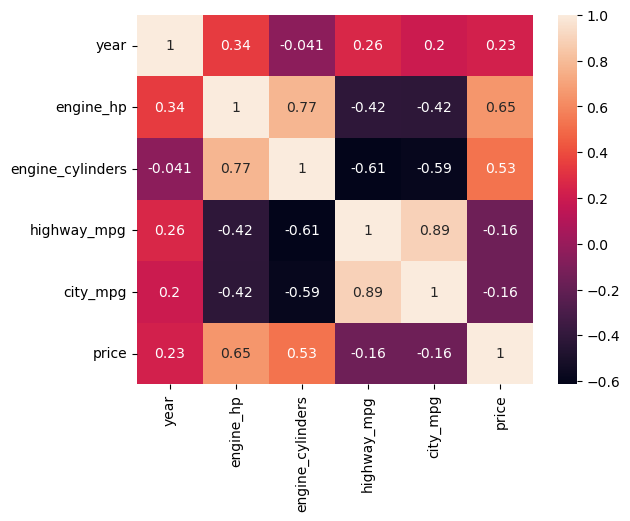

In [17]:
# create a correlation matrix
#plotting the heatmap for correlation
sns.heatmap(car_price.corr(), annot=True)

### Let make price binary

In [18]:
# get the mean price 
mean_price = car_price.price.mean()
mean_price

40594.737032063116

In [19]:
# create a new column **above_average** where 
# it is 1 if price is above mean value and 0 otherwise
def map_price(price):
  if price > mean_price:
    return 1
  else :
    return 0

car_price['above_average'] = car_price["price"].apply(lambda price: map_price(price))


In [20]:
# check 
car_price.head(2)

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1


### Setting Up the validation Network

In [21]:
# let split data
# Split the data into train (60%), validation (20%), and test (20%) sets
# setup the train and test set but we will need a validation
# set so we will still split further
price_full_train, price_test = train_test_split(car_price, test_size = 0.2, 
                                               random_state = 42)
price_train, price_val = train_test_split(price_full_train, test_size = 0.25,
                                         random_state = 1)

# check length of each set, the train and validation
# set must have the same number of rows
len(price_train), len(price_val), len(price_test)

(7148, 2383, 2383)

In [22]:
# reset index of each dataframe
price_train = price_train.reset_index(drop = True)
price_val = price_val.reset_index(drop = True)
price_test = price_test.reset_index(drop = True)

In [23]:
# set your target variable - churn
y_train = price_train.above_average.values
y_val = price_val.above_average.values
y_test = price_test.above_average.values

In [24]:
# delete the churn column from the 3 dataframe
del price_train['above_average']
del price_val['above_average']
del price_test['above_average']

### 3: FEATURE IMPORTANCE: Mutual Information

**model** column hs the HIGHEST mutual information score while **transmission_type** column has the LOWEST

In [42]:
# create function to apply it to all column 
# categorical
def mutual_info(series):
    return mutual_info_score(series, labels_pred = y_train)

In [43]:
# use the function to apply to all columns
# sort the values and round values to 2 decimal values
round((price_train[categorical].apply(mutual_info).sort_values(ascending =False)), 2)

model                0.47
make                 0.24
vehicle_style        0.08
transmission_type    0.02
dtype: float64

### One Hot Encoding

In [27]:
# generate a dictionary
train_dicts = price_train[categorical + numerical].to_dict(orient= 'records')

# initialize encoder
dv = DictVectorizer(sparse = False)
# fit on the train set
X_train = dv.fit_transform(train_dicts)

In [28]:
# generate a dict for val set
val_dicts = price_val[categorical + numerical].to_dict(orient= 'records')
# transform this dictionary of val set
X_val = dv.transform(val_dicts)

### 4: Train the model


In [29]:
# initialize logistic Regression
log_reg = LogisticRegression(solver = 'liblinear', C = 10,
                            max_iter = 1000, random_state = 42)

# fit on the train set
log_reg.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [30]:
# predict on the validation set
y_pred = log_reg.predict(X_val)

In [31]:
# chekc the accuracy score
print(accuracy_score(y_val, y_pred))

0.9995803608896349


In [32]:
# find the score
print(log_reg.score(X_val, y_val))

0.9995803608896349


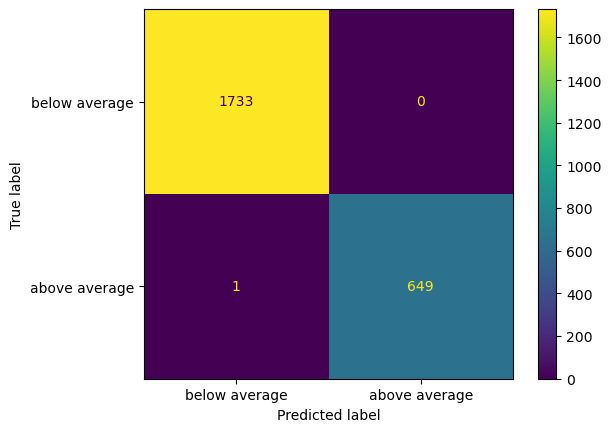

In [33]:
# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                             display_labels=['below average', 'above average'])
disp.plot()
plt.show();

### Perform Feature Importance to Select Best feature


### 6. Linear Regression

In [34]:
# new list 
numerical_new = ['year', 'engine_hp',
             'engine_cylinders', 'highway_mpg',
            'city_mpg']

In [35]:
# set the new target variable
y_train_1 = np.log(price_train.price.values)
y_val_1 = np.log(price_val.price.values)
y_test_1 = np.log(price_test.price.values)

In [36]:
del price_train['price']
del price_val['price']
del price_test['price']

In [37]:
# tranform the train set 
train_new_dicts = price_train[categorical + numerical_new].to_dict(orient= 'records')
X_train_new = dv.transform(train_new_dicts)

In [38]:
# transform the validation set
val_new_dicts = price_val[categorical + numerical_new].to_dict(orient= 'records')
X_val_new = dv.transform(val_new_dicts)

### Training The money and finding the RMSE

In [41]:
alpha = [0, 0.01, 0.1, 1, 10]
for alpha in alpha:
    lin_reg = Ridge(solver = 'sag', random_state = 42,
                       alpha = alpha)
    lin_reg.fit(X_train_new, y_train_1)
    y_pred = lin_reg.predict(X_val_new)
    RMSE = np.sqrt(mean_squared_error(y_val_1, y_pred))
    RMSE = np.round(RMSE, 3)
    print('Alpha: ', alpha, 'RMSE: ', RMSE, )

Alpha:  0 RMSE:  0.475
Alpha:  0.01 RMSE:  0.475
Alpha:  0.1 RMSE:  0.475
Alpha:  1 RMSE:  0.475
Alpha:  10 RMSE:  0.475
